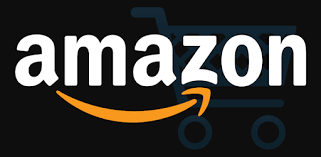

# Loading the Librarys

In [5]:
# pip install textblob
# !pip install wordcloud

In [6]:
import pandas as pd
import numpy as np
# for data cleaning
import string
import re
# for removing accented and special chracters
import unicodedata
# for stopwords Removal
from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize
# for calculating Polarity and Subjectivity
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
# function for making ngrams
from nltk.util import ngrams
# load in all the modules we're going to need
import nltk
import collections
# for Wordscloud
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

# Read the data set

In [9]:
df=pd.read_csv('microwave.tsv', sep='\t')
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,21879631,RY52KZABZK8QF,B0052G14E8,423421857,danby 0.7 cu.ft. countertop microwave,Major Appliances,1,0,0,N,Y,Do not recommend it. go use your money for som...,3 of the buttons stopped working after a month...,8/31/2015
1,US,14964566,R3GCOEV4HYZG2I,B0055UBB4O,423421857,danby 0.7 cu.ft. countertop microwave,Major Appliances,5,0,0,N,Y,Looks as good as the picture,Didn't use it long so I can't attest to that b...,8/31/2015
2,US,13230389,R1V2OPPNL0QGCE,B0052G14E8,423421857,danby 0.7 cu.ft. countertop microwave,Major Appliances,4,0,0,N,Y,Four Stars,"Very nice microwave, great price",8/31/2015
3,US,43655888,R9Q0QDTLKV567,B004ZU09QQ,423421857,danby 0.7 cu.ft. countertop microwave,Major Appliances,3,0,1,N,Y,quiet,"Quiet, but does not seem like 1000 watt power.",8/31/2015
4,US,117794,R3DL7HYC3QTWNI,B005GSZB7I,827502283,"whirlpool stainless look countertop microwave,...",Major Appliances,4,0,0,N,Y,Four Stars,It's bigger than I thought.,8/31/2015


In [10]:
# show the informatiom of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1615 entries, 0 to 1614
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   marketplace        1615 non-null   object
 1   customer_id        1615 non-null   int64 
 2   review_id          1615 non-null   object
 3   product_id         1615 non-null   object
 4   product_parent     1615 non-null   int64 
 5   product_title      1615 non-null   object
 6   product_category   1615 non-null   object
 7   star_rating        1615 non-null   int64 
 8   helpful_votes      1615 non-null   int64 
 9   total_votes        1615 non-null   int64 
 10  vine               1615 non-null   object
 11  verified_purchase  1615 non-null   object
 12  review_headline    1615 non-null   object
 13  review_body        1615 non-null   object
 14  review_date        1615 non-null   object
dtypes: int64(5), object(10)
memory usage: 189.4+ KB


In [11]:
df['review_body']

0       3 of the buttons stopped working after a month...
1       Didn't use it long so I can't attest to that b...
2                        Very nice microwave, great price
3          Quiet, but does not seem like 1000 watt power.
4                             It's bigger than I thought.
                              ...                        
1610    We ordered one of these and were shipped an op...
1611    I do not have this particular microwave; thoug...
1612    Its a pretty big and heavy unit so having some...
1613    UPDATE: Yes i too had the door latch button me...
1614    I purchased this item for two reasons, 1) beca...
Name: review_body, Length: 1615, dtype: object

# Clean the dataset

In [12]:
# First lets remove Punctuations from the Reviews
def punctuation_removal(messy_str):
    clean_list = [char for char in messy_str if char not in string.punctuation]
    clean_str = ''.join(clean_list)
    return clean_str

df['review_body'] = df['review_body'].apply(punctuation_removal)

In [13]:
# lets make a function to remove Numbers from the reviews
def drop_numbers(list_text):
    list_text_new = []
    for i in list_text:
        if not re.search('\d', i):
            list_text_new.append(i)
    return ''.join(list_text_new)

df['review_body'] = df['review_body'].apply(drop_numbers)

In [14]:
# lets show the Top 10 Reviews after Removal of Punctuations and Numbers
df['review_body'].head(10)

0     of the buttons stopped working after a month ...
1    Didnt use it long so I cant attest to that but...
2                      Very nice microwave great price
3             Quiet but does not seem like  watt power
4                            Its bigger than I thought
5    Really love this microwave Has the one touch s...
6    We bought this microwave  years ago as part of...
7    Was pleased with the packaging and easy instru...
8                Neat little unit I have no complaints
9    The finish is nice and matches our stainless s...
Name: review_body, dtype: object

In [15]:
### Removing Accented Characters

"""Accented characters are important elements which are used to signify emphasis on
a particular word during pronunciation or understanding. In some instances, 
the accent mark also clarifies the meaning of a word, which might be different without the accent.
While their use in English is largely limited but there are very good chances 
that you will come across accented characters/letters in a free text corpus. 
Words such as résumé, café, prótest, divorcé, 
coördinate, exposé, latté etc"""
# lets create a function to remove accented characters
def remove_accented_chars(text):
    new_text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return new_text

# lets apply the function
df['review_body'] = df.apply(lambda x: remove_accented_chars(x['review_body']), axis = 1)

In [16]:
# Create a function to remove special characters
def remove_special_characters(text):
    pat = r'[^a-zA-z0-9]' 
    return re.sub(pat, ' ', text)
 
# lets apply this function
df['review_body'] = df.apply(lambda x: remove_special_characters(x['review_body']), axis = 1)

In [18]:
df['review_body'][:10]

0     of the buttons stopped working after a month ...
1    Didnt use it long so I cant attest to that but...
2                      Very nice microwave great price
3             Quiet but does not seem like  watt power
4                            Its bigger than I thought
5    Really love this microwave Has the one touch s...
6    We bought this microwave  years ago as part of...
7    Was pleased with the packaging and easy instru...
8                Neat little unit I have no complaints
9    The finish is nice and matches our stainless s...
Name: review_body, dtype: object

# Feature Engineering

In [19]:
# lets check if the dataset has any Missing Values
df.isnull().sum()

marketplace          0
customer_id          0
review_id            0
product_id           0
product_parent       0
product_title        0
product_category     0
star_rating          0
helpful_votes        0
total_votes          0
vine                 0
verified_purchase    0
review_headline      0
review_body          0
review_date          0
dtype: int64

In [20]:
# Lets calculate the length of the Reviews
df['length'] = df['review_body'].apply(len)

### Text Polarity

It is the expression that determines the sentimental aspect of an opinion. In textual data, the result of sentiment analysis can be determined for each entity in the sentence, document or sentence. The sentiment polarity can be determined as positive, negative and neutral.

In [21]:
# Lets calculate the Polarity of the Reviews
def get_polarity(text):
    textblob = TextBlob(str(text.encode('utf-8')))
    pol = textblob.sentiment.polarity
    return pol

# lets apply the function
df['polarity'] = df['review_body'].apply(get_polarity)

### Text Subjectivity

In natural language, subjectivity refers to expression of opinions, evaluations, feelings, and speculations and thus incorporates sentiment. Subjective text is further classified with sentiment or polarity.

In [22]:
# Lets calculate the Subjectvity of the Reviews
def get_subjectivity(text):
    textblob = TextBlob(str(text.encode('utf-8')))
    subj = textblob.sentiment.subjectivity
    return subj

# lets apply the Function
df['subjectivity'] = df['review_body'].apply(get_subjectivity)

In [23]:
## lets summarize the Newly Created Features
df[['length','polarity','subjectivity']].describe()

,length,polarity,subjectivity
count,1615.000000,1615.000000,1615.000000
mean,442.642724,0.209742,0.531967
std,673.859364,0.265860,0.192727
min,2.000000,-1.000000,0.000000
25%,113.000000,0.036265,0.433333
50%,246.000000,0.170820,0.533333
75%,510.000000,0.350000,0.639689
max,9948.000000,1.000000,1.000000


In [24]:
# calculating the Character Count in the Reviews
df['char_count'] = df['review_body'].apply(len)

In [25]:
# calculating the Word Count
df['word_count'] = df['review_body'].apply(lambda x: len(x.split()))

In [26]:
# Calculating the Word Density
df['word_density'] = df['char_count'] / (df['word_count']+1)

In [27]:
# importing the List of Punctuations
import string
punctuation = string.punctuation

# Calculating the Punctuation Count
df['punctuation_count'] = df['review_body'].apply(lambda x: len("".join(_ for _ in x if _ in punctuation))) 

In [28]:
## lets summarize the Newly Created Features
df[['char_count','word_count','word_density','punctuation_count']].describe()

,char_count,word_count,word_density,punctuation_count
count,1615.000000,1615.000000,1615.000000,1615.0
mean,442.642724,82.695975,5.071803,0.0
std,673.859364,123.559817,0.603113,0.0
min,2.000000,1.000000,1.000000,0.0
25%,113.000000,22.000000,4.842928,0.0
50%,246.000000,46.000000,5.155556,0.0
75%,510.000000,97.000000,5.401519,0.0
max,9948.000000,1779.000000,6.976744,0.0


# Make Visulization

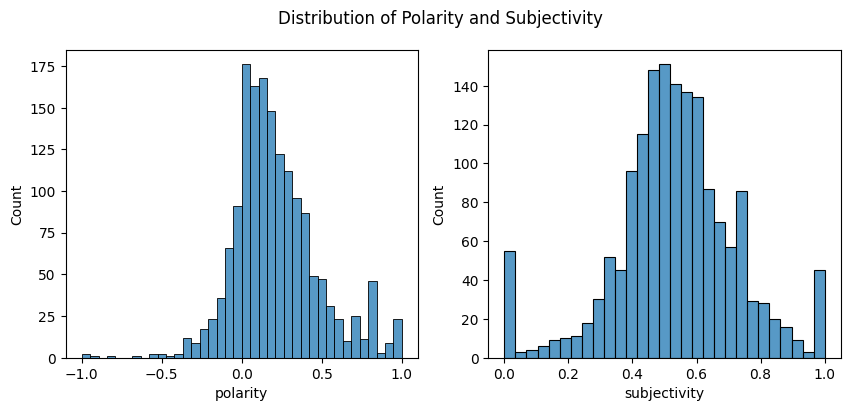

In [30]:
## Visualizing Polarity and Subjectivity

plt.rcParams['figure.figsize'] = (10, 4)

plt.subplot(1, 2, 1)
sns.histplot(df['polarity'])

plt.subplot(1, 2, 2)
sns.histplot(df['subjectivity'])

plt.suptitle('Distribution of Polarity and Subjectivity')
plt.show()

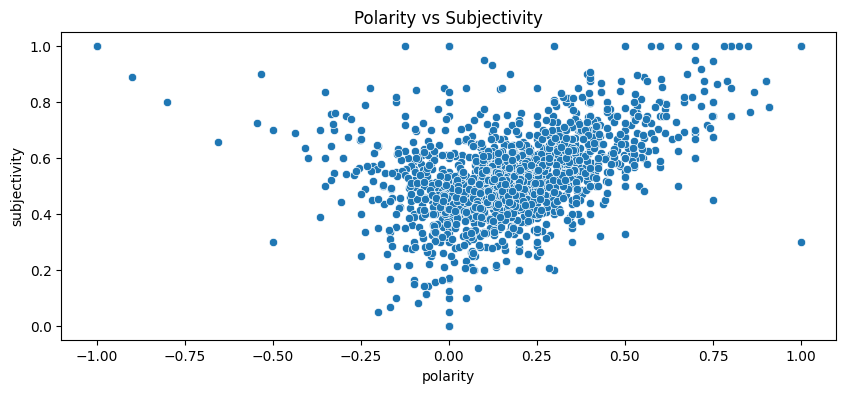

In [32]:
# lets check relation between Polarity and Subjectivity

sns.scatterplot(x=df['polarity'], y=df['subjectivity'])
plt.title('Polarity vs Subjectivity')
plt.show()

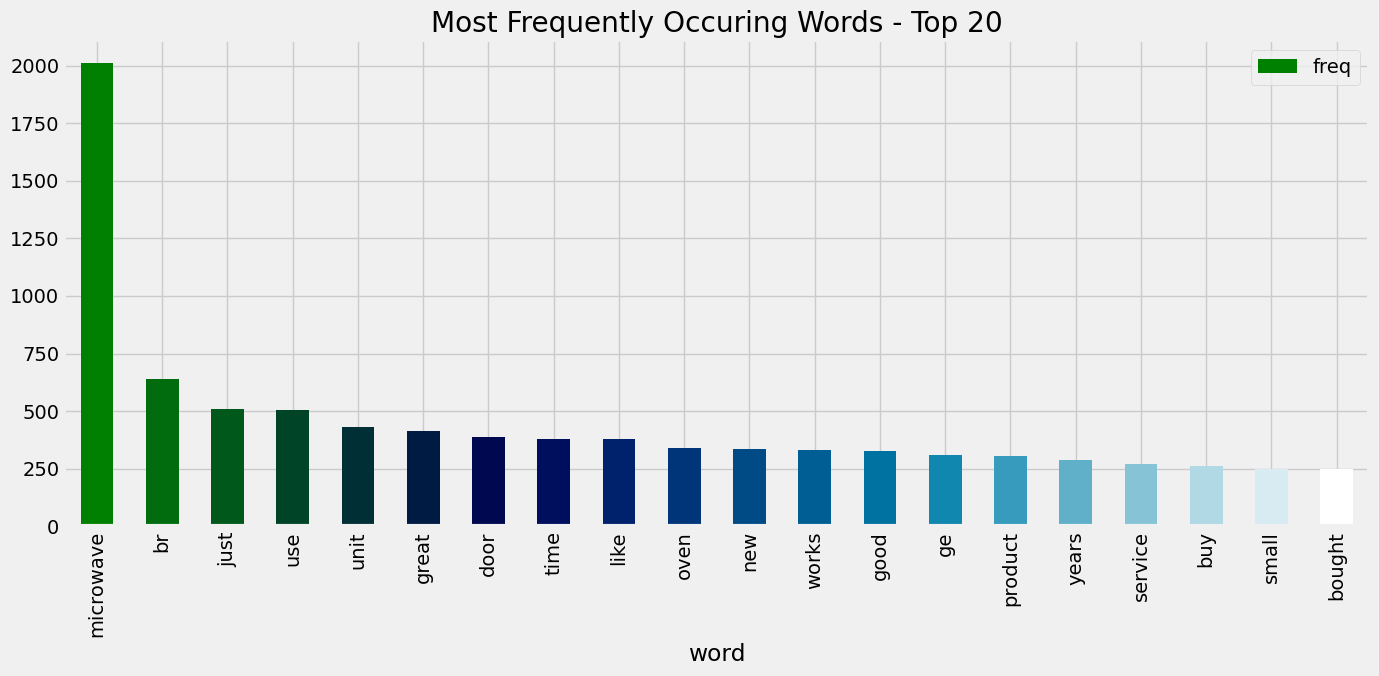

In [34]:
## Visualizing the Most Frequent Words

from sklearn.feature_extraction.text import CountVectorizer


cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(df.review_body)
sum_words = words.sum(axis=0)


words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

plt.style.use('fivethirtyeight')
color = plt.cm.ocean(np.linspace(0, 1, 20))
frequency.head(20).plot(x='word', y='freq', kind='bar', figsize=(15, 6), color = color)
plt.title("Most Frequently Occuring Words - Top 20")
plt.show()

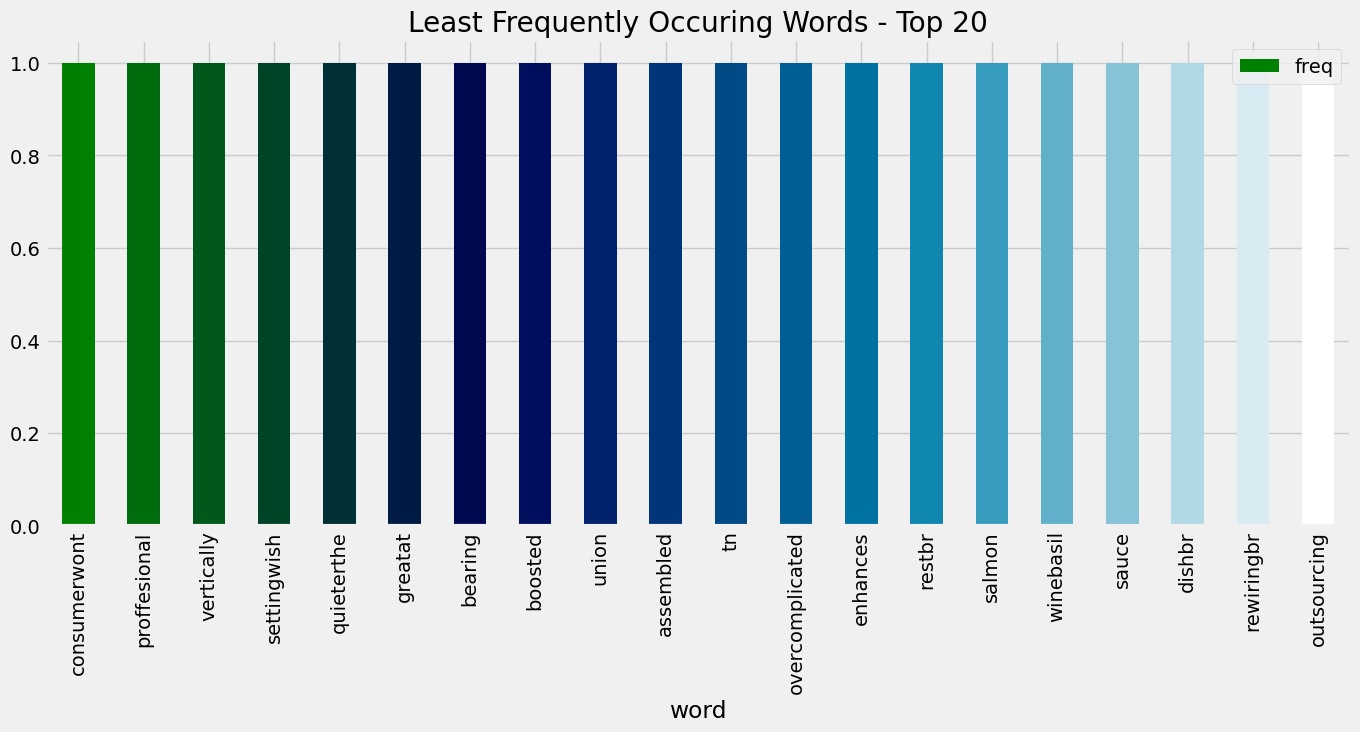

In [36]:
## Visualizing the Least Frequent Words

from sklearn.feature_extraction.text import CountVectorizer


cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(df.review_body)
sum_words = words.sum(axis=0)


words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

plt.style.use('fivethirtyeight')
color = plt.cm.ocean(np.linspace(0, 1, 20))
frequency.tail(20).plot(x='word', y='freq', kind='bar', figsize=(15, 6), color = color)
plt.title("Least Frequently Occuring Words - Top 20")
plt.show()

# Visualizing the BiGrams

In [37]:
# Visualizing the BiGrams

text = str(df['review_body'])
tokenized = text.split()

# and get a list of all the bi-grams
esBigrams = ngrams(tokenized, 2)

# get the frequency of each bigram in our corpus
esBigramFreq = collections.Counter(esBigrams)

# what are the ten most popular ngrams in this Spanish corpus?
esBigramFreq.most_common(10)

[(('0', 'of'), 1),
 (('of', 'the'), 1),
 (('the', 'buttons'), 1),
 (('buttons', 'stopped'), 1),
 (('stopped', 'working'), 1),
 (('working', 'after'), 1),
 (('after', 'a'), 1),
 (('a', 'month'), 1),
 (('month', '...'), 1),
 (('...', '1'), 1)]

In [38]:
# Visualizing the Trigrams

text = str(df['review_body'])
tokenized = text.split()

# and get a list of all the bi-grams
esTrigrams = ngrams(tokenized, 3)

# get the frequency of each bigram in our corpus
esTrigramFreq = collections.Counter(esTrigrams)

# what are the ten most popular ngrams in this Spanish corpus?
esTrigramFreq.most_common(10)

[(('0', 'of', 'the'), 1),
 (('of', 'the', 'buttons'), 1),
 (('the', 'buttons', 'stopped'), 1),
 (('buttons', 'stopped', 'working'), 1),
 (('stopped', 'working', 'after'), 1),
 (('working', 'after', 'a'), 1),
 (('after', 'a', 'month'), 1),
 (('a', 'month', '...'), 1),
 (('month', '...', '1'), 1),
 (('...', '1', 'Didnt'), 1)]

In [39]:
# Defining a function to visualise n-grams
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

<Axes: >

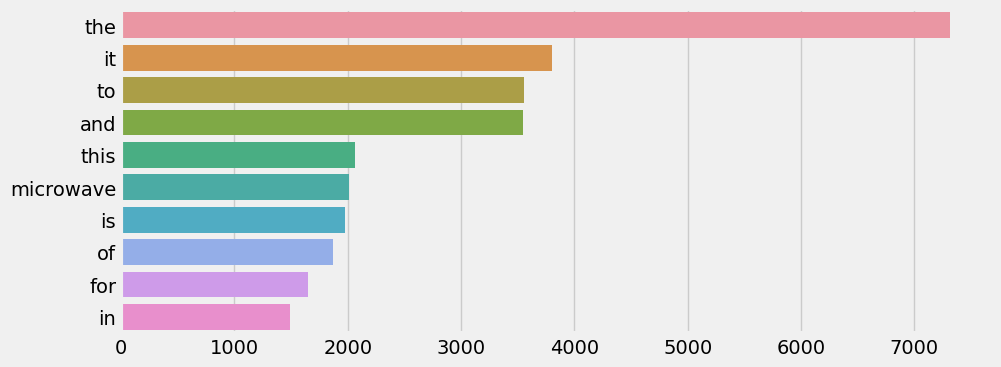

In [40]:
# Visualising the most frequent unigrams in the tweets
top_unigrams = get_top_ngram(df['review_body'],1)[:10]
x,y = map(list,zip(*top_unigrams))
sns.barplot(x = y,y = x)

<Axes: >

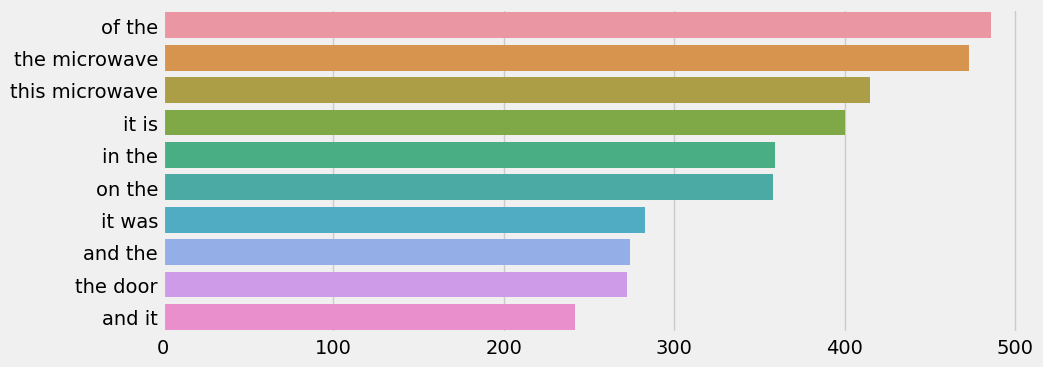

In [41]:
# Visualising the most frequent bigrams in the tweets
top_bigrams = get_top_ngram(df['review_body'],2)[:10]
x,y = map(list,zip(*top_bigrams))
sns.barplot(x = y,y = x)

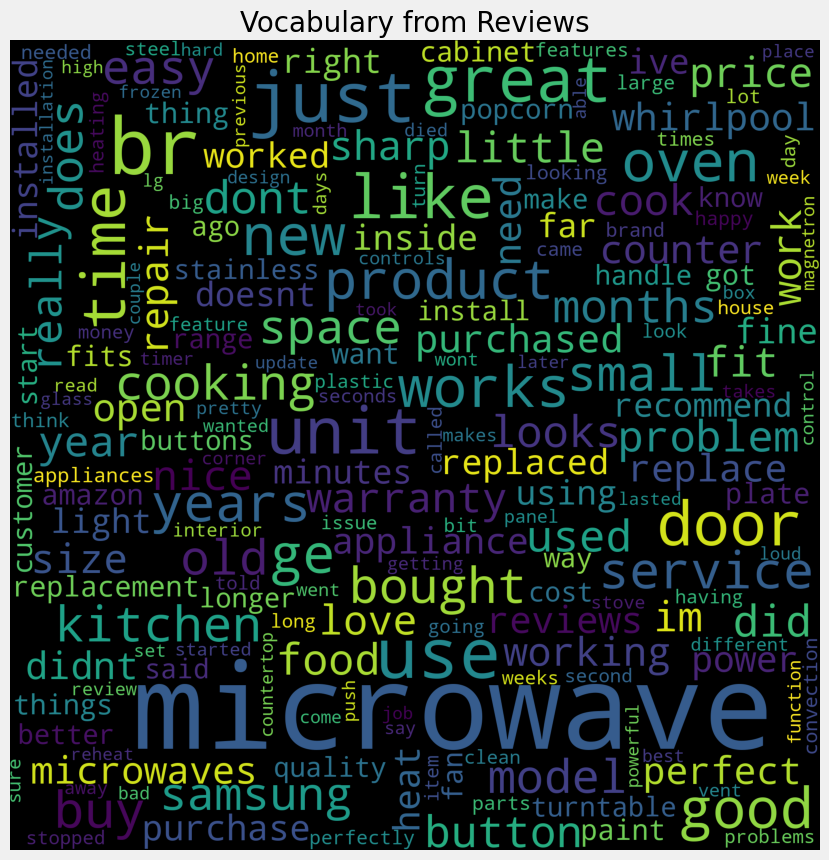

In [42]:
# lets plot the Wordscloud

cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(df.review_body)
sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

wordcloud = WordCloud(background_color = 'black', width = 2000, height = 2000).generate_from_frequencies(dict(words_freq))

plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(wordcloud)
plt.title("Vocabulary from Reviews", fontsize = 20)
plt.show()

# Show The Sentiment Analysis

In [43]:
# Lets calculate the Polarity of the Reviews
def get_polarity(text):
    textblob = TextBlob(str(text))
    pol = textblob.sentiment.polarity
    if(pol==0):
        return "Neutral"
    elif(pol>0 and pol<=0.3):
        return "Weakly Positive"
    elif(pol>0.3 and pol<=0.6):
        return "Positive"
    elif(pol>0.6 and pol<=1):
        return "Strongly Positive"
    elif(pol>-0.3 and pol<=0):
        return "Weakly Negative"
    elif(pol>-0.6 and pol<=-0.3):
        return "Negative"
    elif(pol>-1 and pol<=-0.6):
        return "Strongly Negative"
    
df['polarity'] = df['review_body'].apply(get_polarity)

In [44]:
df['polarity'].value_counts()

Weakly Positive      776
Positive             357
Weakly Negative      239
Strongly Positive    138
Neutral               78
Negative              22
Strongly Negative      3
Name: polarity, dtype: int64

In [45]:
neutral = 0
wpositive = 0
spositive = 0
positive = 0
negative = 0
wnegative = 0
snegative = 0
polarity = 0

for i in range(0,70):
    textblob = TextBlob(str(df['review_body'][i]))
    polarity+= textblob.sentiment.polarity
    pol = textblob.sentiment.polarity
    if (pol == 0):  # adding reaction of how people are reacting to find average later
        neutral += 1
    elif (pol > 0 and pol <= 0.3):
        wpositive += 1
    elif (pol > 0.3 and pol <= 0.6):
        positive += 1
    elif (pol > 0.6 and pol <= 1):
        spositive += 1
    elif (pol > -0.3 and pol <= 0):
        wnegative += 1
    elif (pol > -0.6 and pol <= -0.3):
        negative += 1
    elif (pol > -1 and pol <= -0.6):
        snegative += 1


In [46]:
# input for term to be searched and how many Review to search
searchTerm = input("Enter Keyword/Tag to search about: ")
NoOfTerms = int(input("Enter how many tweets to search: "))

Enter Keyword/Tag to search about: 200
Enter how many tweets to search: 200


In [47]:
# finding average reaction
polarity = polarity / NoOfTerms
polarity

0.10249608647746118

In [48]:
# To calculate the Prsentage
def percentage(part, whole):
    temp = 100 * float(part) / float(whole)
    return format(temp, '.2f')

In [49]:
 # finding average of how people are reacting
positive = percentage(positive, NoOfTerms)
wpositive = percentage(wpositive, NoOfTerms)
spositive = percentage(spositive, NoOfTerms)
negative = percentage(negative, NoOfTerms)
wnegative = percentage(wnegative, NoOfTerms)
snegative = percentage(snegative, NoOfTerms)
neutral = percentage(neutral, NoOfTerms)


In [50]:
 # printing out data
print("How people are reacting on " + searchTerm + " by analyzing " + str(NoOfTerms) + " Review.")
print()
print("-----------------------------------------------------------------------------------------")
print()
print("General Report: ")

if (polarity == 0):
    print("Neutral")
elif (polarity > 0 and polarity <= 0.3):
    print("Weakly Positive")
elif (polarity > 0.3 and polarity <= 0.6):
    print("Positive")
elif (polarity > 0.6 and polarity <= 1):
    print("Strongly Positive")
elif (polarity > -0.3 and polarity <= 0):
    print("Weakly Negative")
elif (polarity > -0.6 and polarity <= -0.3):
    print("Negative")
elif (polarity > -1 and polarity <= -0.6):
    print("Strongly Negative")

print()
print("------------------------------------------------------------------------------------------")
print()
print("Detailed Report: ")
print(str(positive) + "% people thought it was positive")
print(str(wpositive) + "% people thought it was weakly positive")
print(str(spositive) + "% people thought it was strongly positive")
print(str(negative) + "% people thought it was negative")
print(str(wnegative) + "% people thought it was weakly negative")
print(str(snegative) + "% people thought it was strongly negative")
print(str(neutral) + "% people thought it was neutral")

How people are reacting on 200 by analyzing 200 Review.

-----------------------------------------------------------------------------------------

General Report: 
Weakly Positive

------------------------------------------------------------------------------------------

Detailed Report: 
8.50% people thought it was positive
14.50% people thought it was weakly positive
5.50% people thought it was strongly positive
0.50% people thought it was negative
3.50% people thought it was weakly negative
0.00% people thought it was strongly negative
2.50% people thought it was neutral


In [51]:
# Define the sentance to Plot the Pieplot 
sizes = [positive, wpositive, spositive, neutral, negative, wnegative, snegative]
colors = ['yellowgreen','lightgreen','darkgreen', 'gold', 'red','lightsalmon','darkred']
labels = ['Positive [' + str(positive) + '%]', 'Weakly Positive [' + str(wpositive) + '%]',
          'Strongly Positive [' + str(spositive) + '%]', 'Neutral [' + str(neutral) + '%]',
          'Negative [' + str(negative) + '%]', 'Weakly Negative [' + str(wnegative) + '%]', 
          'Strongly Negative [' + str(snegative) + '%]']

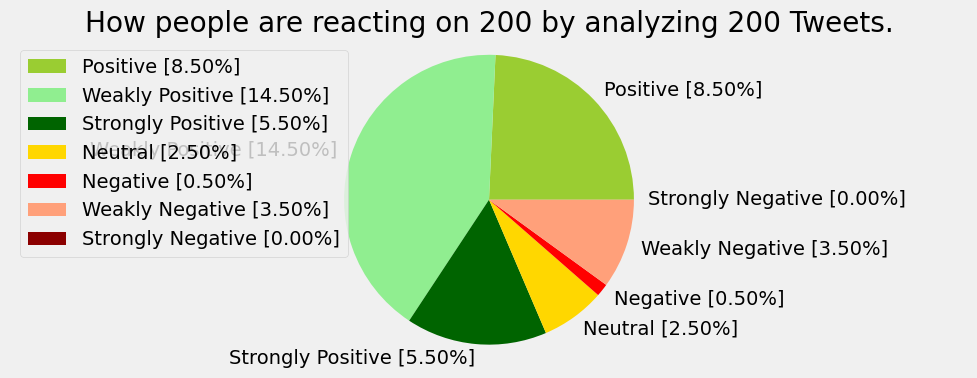

In [52]:
plt.pie(sizes, labels = labels, colors = colors)
plt.legend(labels, loc="best")
plt.title('How people are reacting on ' + searchTerm + ' by analyzing ' + str(NoOfTerms) + ' Tweets.')
plt.axis('equal')
plt.tight_layout()
plt.show()